<a href="https://colab.research.google.com/github/heisdenverr/openeyelvm/blob/master-branch/Experiments_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.4.0+cu121
0.19.0+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4183, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 4183 (delta 65), reused 98 (delta 40), pack-reused 4035 (from 1)
Receiving objects: 100% (4183/4183), 652.89 MiB | 30.58 MiB/s, done.
Resolving deltas: 100% (2436/2436), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def set_seeds(seed: int=42):
  """
    Set random seed for torch operations

    Args: seed -> int [Default:42..int]

  """
  torch.manual_seed(seed)

  torch.cuda.manual_seed(42)

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source:str,
                  destination: str,
                  remove_source: bool=True) -> Path:

  """ Downloads a zip from Source and zips to Destination """

  data_path = Path("data/")
  image_path = data_path / destination

  if image_path.is_dir():
    print(f"[INFO] {image_path} already exists, skipping download")

  else:
    print(f"[INFO] did not found {image_path} downloading")
    image_path.mkdir(parents=True, exist_ok=True)

    target_file = Path(source).name
    with open(data_path / target_file, "wb") as f:
      request = requests.get(source)
      print(f"[INFO] Downloading {target_file} from {source}...")
      f.write(request.content)

    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
      zip_ref.extractall(image_path)

    if remove_source:
      os.remove(data_path / target_file)

  return image_path

In [ ]:

os.mkdir("data1/")

In [ ]:

t_zip = zip_path / train_zip
t_zip


PosixPath('data1/data1')

In [ ]:
zip_path = Path("data1/train.zip")
image_path = Path("data1/train")

In [ ]:
 with zipfile.ZipFile(zip_path, "r") as zip_r:
    zip_r.extractall(image_path)

In [ ]:
train_dir = image_path
test_dir = image_path
BATCH_SIZE = NUM_WORKERS = 4, 2

In [ ]:
os.cpu_count()

2

In [ ]:
BATCH_SIZE = NUM_WORKERS = 4, os.cpu_count()

weights = torchvision.models.ResNet50_Weights.DEFAULT
model = torchvision.models.resnet50(weights=weights).to(device)

auto_transform = weights.transforms()

In [ ]:
from torchvision import datasets

In [ ]:
set_seeds()
train_data = datasets.ImageFolder(train_dir,
                                  auto_transform,
                                  )
test_data = datasets.ImageFolder(test_dir,
                                 auto_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 30
     Root location: data1/train
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[232]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BILINEAR
            ),
 Dataset ImageFolder
     Number of datapoints: 30
     Root location: data1/train
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[232]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BILINEAR
            ))

In [ ]:
from torch.utils import data

In [ ]:

train_loader = data.DataLoader(dataset=train_data,
                               batch_size=16,
                               shuffle=True,
                              )
test_loader = data.DataLoader(dataset=test_data,
                              batch_size=16,
                              shuffle=False,
                              )
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7e97f414ace0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e97f4148880>)

In [ ]:
img, label = next(iter(train_loader))
img.shape, label.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [ ]:
class_names = train_data.classes
class_idx = train_data.class_to_idx

In [ ]:
# Delete fc layer
modules = list(model.children())[:-1]
resnet = nn.Sequential(*modules)
# Set grad to false
for params in resnet.parameters():
  params.requires_grad = False

# Add last layer
resnet.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=len(class_names))
)
resnet.fc

Sequential(
  (0): Linear(in_features=2048, out_features=3, bias=True)
)

In [ ]:
summary(model=model,
        input_size=(1, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    │    

In [ ]:
set_seeds()

from timeit import default_timer as timer
start_time = timer()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
results = engine.train(model=model,
                train_dataloader=train_loader,
                test_dataloader=test_loader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=20,
                device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0004 | train_acc: 1.0000 | test_loss: 0.0001 | test_acc: 1.0000
Epoch: 2 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 0.0000 | test_acc: 1.0000
Epoch: 3 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.0001 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 0.0000 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 0.0000 | test_acc: 1.0000
Epoch: 6 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 0.0000 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.0000 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.0000 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.0000 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.0000 | test_acc: 1.0000
Epoch: 11 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.0000 | test_acc: 1.0000
Epoch: 12 | train_l

In [ ]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

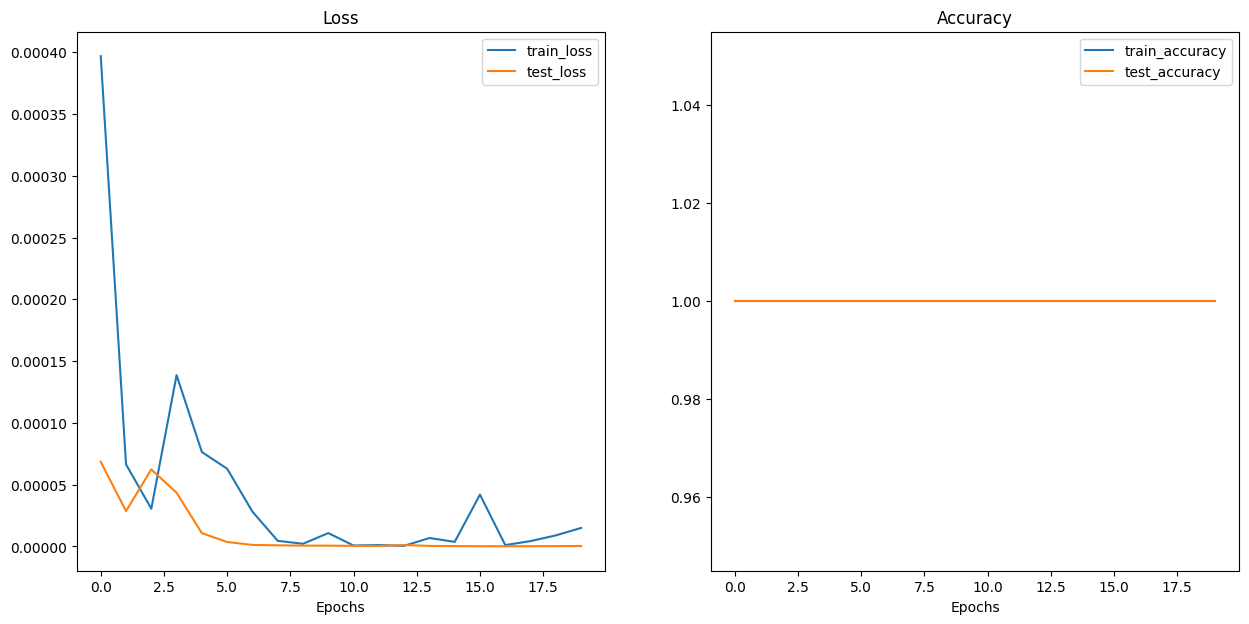

In [ ]:
plot_loss_curves(results=results)

In [ ]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

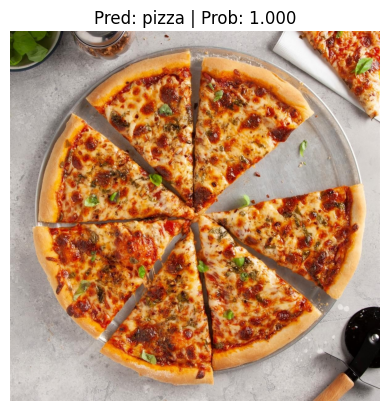

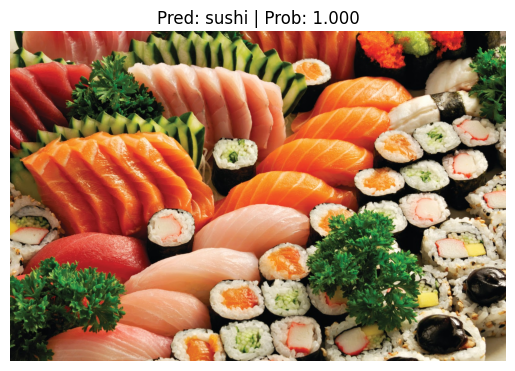

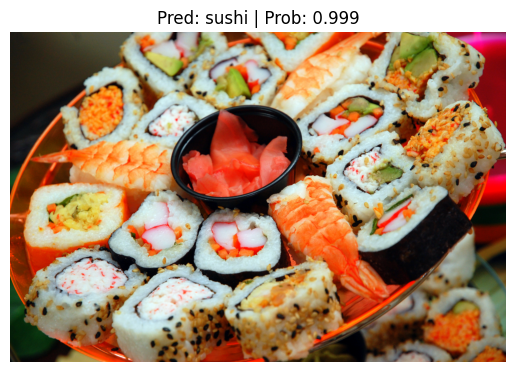

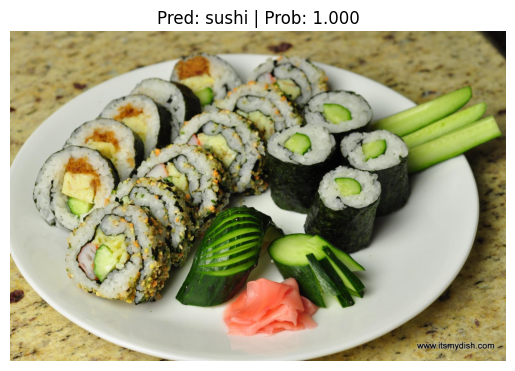

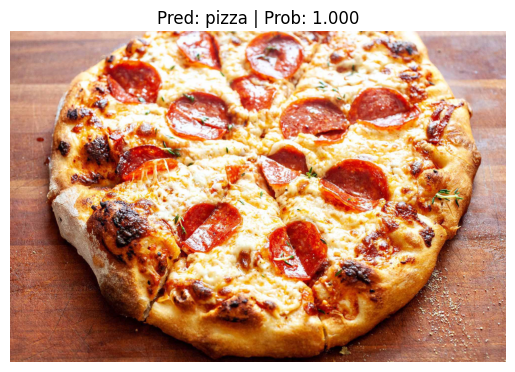

In [ ]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 5
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

In [ ]:
train_log_loss = [ -7.83, -9.62, -10.40, -8.88, -9.48, -9.67, -10.48, -12.31, -13.05, -11.44, -14.11, -13.72, -14.62, -11.90, -12.51, -10.08, -13.74, -12.35, -11.63, -11.11]
test_log_loss = [ -9.59, -10.46, -9.68, -10.04, -11.44, -12.54, -13.62, -13.94, -14.28, -14.29, -14.59, -14.78, -13.70, -14.70, -15.11, -15.61, -15.55, -15.51, -15.17, -14.96]

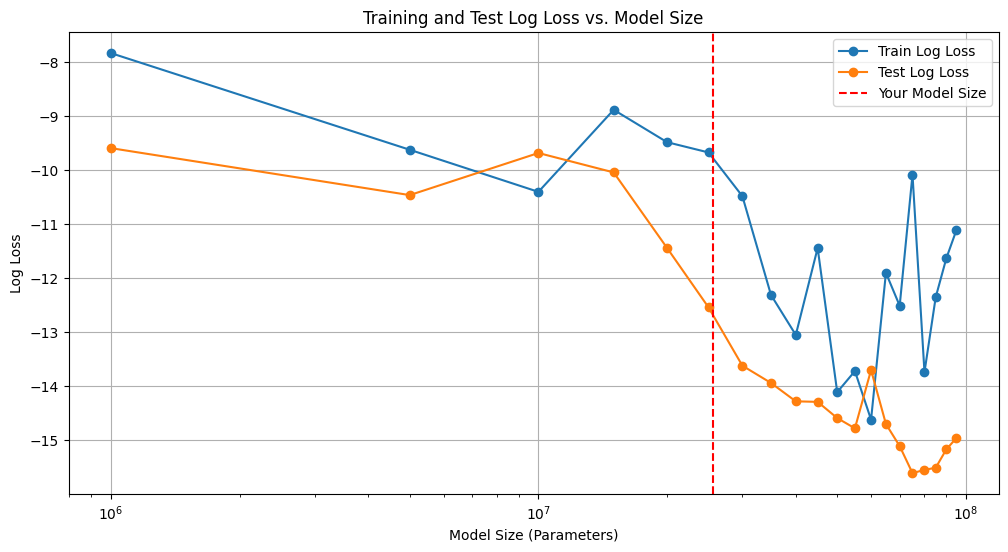

In [ ]:
import matplotlib.pyplot as plt

# Model sizes corresponding to log loss values
model_sizes = [1e6, 5e6, 1e7, 1.5e7, 2e7, 2.5e7, 3e7, 3.5e7, 4e7, 4.5e7, 5e7, 5.5e7, 6e7, 6.5e7, 7e7, 7.5e7, 8e7, 8.5e7, 9e7, 9.5e7]  # Hypothetical sizes
train_log_loss = [-7.83, -9.62, -10.40, -8.88, -9.48, -9.67, -10.48, -12.31, -13.05, -11.44, -14.11, -13.72, -14.62, -11.90, -12.51, -10.08, -13.74, -12.35, -11.63, -11.11]
test_log_loss = [-9.59, -10.46, -9.68, -10.04, -11.44, -12.54, -13.62, -13.94, -14.28, -14.29, -14.59, -14.78, -13.70, -14.70, -15.11, -15.61, -15.55, -15.51, -15.17, -14.96]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(model_sizes, train_log_loss, label='Train Log Loss', marker='o')
plt.plot(model_sizes, test_log_loss, label='Test Log Loss', marker='o')
plt.axvline(x=25.557e6, color='r', linestyle='--', label='Your Model Size')  # Mark your model size
plt.xlabel('Model Size (Parameters)')
plt.ylabel('Log Loss')
plt.title('Training and Test Log Loss vs. Model Size')
plt.xscale('log')  # Use logarithmic scale for better visualization
plt.legend()
plt.grid(True)
plt.show()


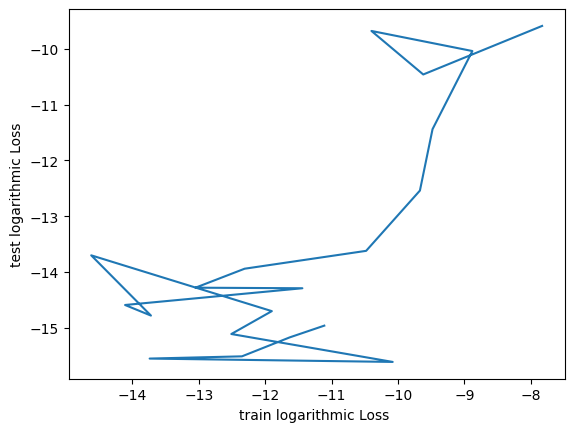

In [ ]:
plt.plot(train_log_loss, test_log_loss)
plt.xlabel("train logarithmic Loss ")
plt.ylabel("test logarithmic Loss")
plt.show();

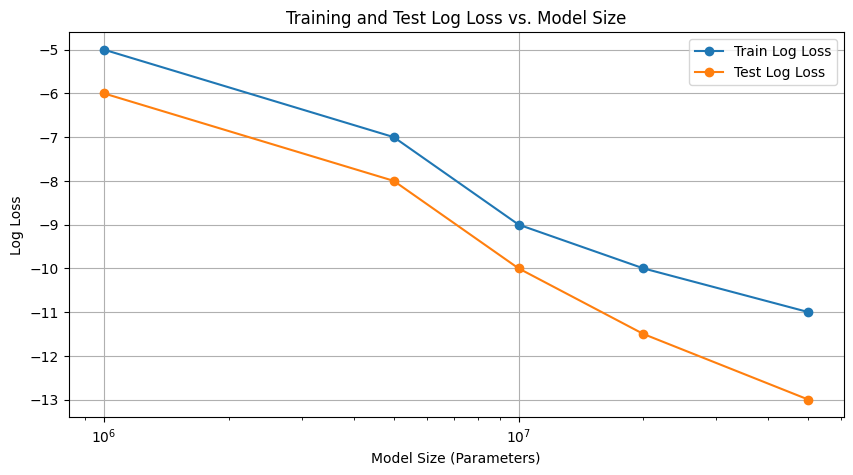

In [ ]:
import matplotlib.pyplot as plt

# Hypothetical data for different model sizes
model_sizes = [1e6, 5e6, 1e7, 2e7, 5e7]  # Model sizes in parameters
train_log_loss = [-5.0, -7.0, -9.0, -10.0, -11.0]  # Hypothetical training log loss
test_log_loss = [-6.0, -8.0, -10.0, -11.5, -13.0]  # Hypothetical test log loss

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(model_sizes, train_log_loss, label='Train Log Loss', marker='o')
plt.plot(model_sizes, test_log_loss, label='Test Log Loss', marker='o')
plt.xlabel('Model Size (Parameters)')
plt.ylabel('Log Loss')
plt.title('Training and Test Log Loss vs. Model Size')
plt.xscale('log')  # Use logarithmic scale for better visualization
plt.legend()
plt.grid(True)
plt.show()